In [25]:
import numpy as np
import pandas as pd

In [26]:
import os
import json
import string
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

In [27]:
# What are the contents of the reports roughly? [ Create a word cloud for the dataset ]
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [28]:
rpt2020=pd.read_excel('2020 All Reviews.xlsx')  
rpt2019=pd.read_excel('2019 All Reviews.xlsx')  
rpt2018=pd.read_excel('2018 All Reviews.xlsx')  
rpt=rpt2020.append(rpt2019)
rpt=rpt.append(rpt2018)

# Basic exploratory  of Review Text

In [6]:
## 1) Number of reviews
len(rpt['Review Text'])

414440

In [7]:
## 2) How many missing reviews?
rpt['Review Text'].isna().sum()

122217

In [29]:
## 2.1) Remove the NA
rpt1 = rpt[rpt['Review Text'].notna()]

In [30]:
## 3) Filter non-english reviews
rpt2=rpt1[rpt1['Language']=='en']

In [31]:
## 3.1) Further filtering for misclassified 'en'
rpt4=rpt2[~rpt2['Review Text'].str.contains(r'[^\x00-\x7F]+')]

In [32]:
## 3.2) check number of valid reviews
rpt4.reset_index()
len(rpt4['Review Text'])

103434

In [26]:
len(rpt4['Hotel Name'].unique())

185

In [28]:
len(rpt4['Country'].unique())

201

In [33]:
## 4) tokenize word
tokens = [ word_tokenize(d) for d in rpt4['Review Text']]

In [13]:
## 4) how many unique words/total words? view freq occurring words
tokens_flatten = [d for t in tokens for d in t]
unique=set(tokens_flatten)
len(unique)/len(tokens_flatten)
## not much repeated words

0.01314274970233692

# Text Processing

In [34]:
## define stopword, stemming functions, POS Tag

mystopwords=stopwords.words("English")+['hotel','...']
#mystopwords=stopwords.words("English") +["'s",'injured','kill', 'two', 'one']
WNlemma = nltk.WordNetLemmatizer()
snowball = nltk.SnowballStemmer('english')
porter = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()

# Lemmatize with POS Tag
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


In [35]:
## define preprocess
## lower text
## remove stopwords
## remove numeric
#wnl = nltk.WordNetLemmatizer()

def preprocess(toks):
    toks = [ t.lower() for t in toks if t not in string.punctuation+"’“”" ]
    toks = [ WNlemma.lemmatize(t.lower(), get_wordnet_pos(t.lower())) for t in toks]
    #toks = [ lancaster.stem(t) for t in toks ] 
    toks = [t for t in toks if t not in mystopwords ]
    #toks = [ t for t in toks if nltk.pos_tag(t)[1]!='JJ']
    toks = [ t for t in toks if not t.isnumeric() ]
    toks = [ snowball.stem(t) for t in toks ]
    toks = [ t for t in toks if len(t) >= 3 ]
    #toks=[ porter.stem(t) for t in toks ] 
    
#    toks = [ wnl.lemmatize(t) for t in toks ]
    return toks



In [36]:
# Apply preprocessing to every document in the training set.

cat=rpt4['Review Text']
#toks1 = [ word_tokenize(f) for f in cat ] 
toks1 = tokens
toks2 = [ preprocess(f) for f in toks1]


In [37]:
## create synomyn dictionaries
hyps_room = list(set(
                [w for s in wn.synsets('bedroom')[0].closure(lambda s:s.hyponyms())
                        for w in s.lemma_names()]))

hyps_beverage = list(set(
                [w for s in wn.synsets('beverage')[0].closure(lambda s:s.hyponyms())
                        for w in s.lemma_names()]))  
hyps_food = list(set(
                [w for s in wn.synsets('food')[0].closure(lambda s:s.hyponyms())
                        for w in s.lemma_names()]))    
hyps_meal = list(set(
                [w for s in wn.synsets('meal')[0].closure(lambda s:s.hyponyms())
                        for w in s.lemma_names()]))   
hyps_hotel = list(set(
                [w for s in wn.synsets('hotel')[0].closure(lambda s:s.hyponyms())
                        for w in s.lemma_names()]))   
hyps_restaurant = list(set(
                [w for s in wn.synsets('restaurant')[0].closure(lambda s:s.hyponyms())
                        for w in s.lemma_names()]))  
hyps_value = list(set(
                [w for s in wn.synsets('value')[1].closure(lambda s:s.hyponyms())
                        for w in s.lemma_names()])) 
hyps_sleep = list(set(
                [w for s in wn.synsets('sleep')[0].closure(lambda s:s.hyponyms())
                        for w in s.lemma_names()])) 
hyps_location = list(set(
                [w for s in wn.synsets('location')[0].closure(lambda s:s.hyponyms())
                        for w in s.lemma_names()])) 
hyps_service = list(set(
                [w for s in wn.synsets('service')[0].closure(lambda s:s.hyponyms())
                        for w in s.lemma_names()]))
hyps_facility = list(set(
                [w for s in wn.synsets('facility')[0].closure(lambda s:s.hyponyms())
                        for w in s.lemma_names()]))

In [38]:
hyps_room= hyps_room+[ snowball.stem(t) for t in ["room",'size','bathroom', 'shower','bath','sofa','fridge','wash','machine','clean','dirty','toilet',
                                                 'dryer','view'] ]
hyps_value=hyps_value+[ snowball.stem(t) for t in['value','price','worth','low','high','expensive','cheap','rate','money','economical','reasonable','fee']]
hyps_sleep= hyps_sleep+[ snowball.stem(t) for t in['sleep','bed','bedroom']]
hyps_location=hyps_location+[ snowball.stem(t) for t in['location','place','metro','station','train','mall','shopping','far','near','distance','close',
                                                       'convenient','airport']]
hyps_service=[ snowball.stem(t) for t in['service','staff','reception','desk','housekeeping','check','fast','request','help','good','polite', 'friendly',
                                        'reliable','quick','slow']]
hyps_facility=hyps_facility+[ snowball.stem(t) for t in['facility','wifi','pool','swimming','gym','entertainment','wi','fi','internet',
                                                       'wireless','parking','damage','broken']]

In [39]:
## replace similar words
#class_cat=[]
#check =  any(item in List1 for items in List2)
#class_cat2=[]
toks2_syn=toks2
for sent in toks2_syn:
    for index, c in enumerate(sent):
        
        if c in hyps_room:
            sent[index]='room'
        elif c in hyps_beverage:
            sent[index]='food'
        elif c in hyps_food:
            sent[index]='food'    
        elif c in hyps_meal:
            sent[index]='food'    
        elif c in hyps_hotel:
            sent[index]='hotel'    
        elif c in hyps_restaurant:
            sent[index]='restaurant' 
        elif c in hyps_value:
            sent[index]='value'
        elif c in hyps_sleep:
            sent[index]='sleep_quality'
        elif c in hyps_location:
            sent[index]='location'
        elif c in hyps_service:
            sent[index]='service'
        elif c in hyps_facility:
            sent[index]='facility'
        else:
            sent[index]=sent[index]
#return toks2
        #class_cat=[''.join(oc)]
    #class_cat2.append(text)

In [136]:
# flatten token
toks2_flat = [ c for l in toks2 for c in l ]
text_clean = [ ' '.join(f) for f in toks2_flat ]

In [40]:
# flatten token
toks2_flat_syn = [ c for l in toks2_syn for c in l ]
text_clean = [ ' '.join(f) for f in toks2_flat_syn ]

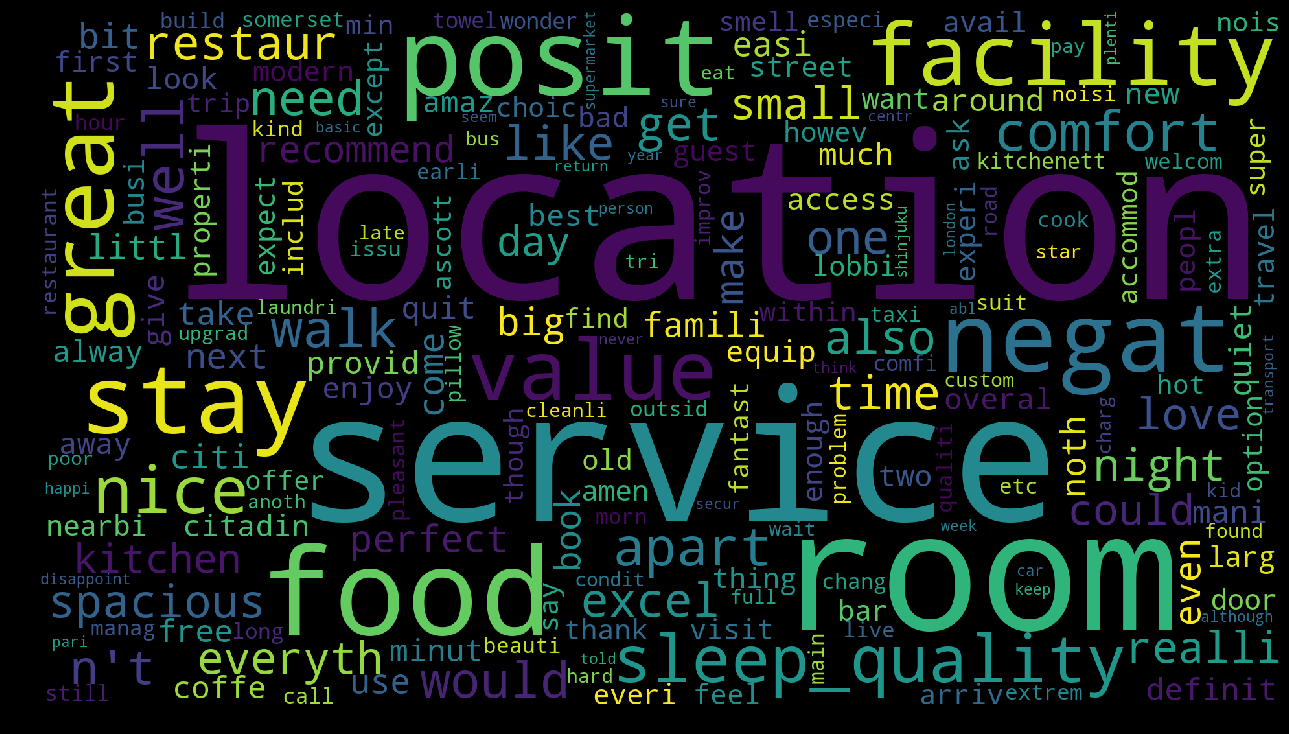

In [53]:
## unigram word cloud ==> unsupervised to determine aspect/topics

fd_toks2 = FreqDist(toks2_flat_syn)
#fd_toks2.most_common(100)

# What are the contents of the reports roughly? [ Create a word cloud for the dataset ]
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 




wordcloud3 = wordcloud.WordCloud(width = 1920, height = 1080).generate_from_frequencies(fd_toks2)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud3)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [41]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## LDA for syn

In [43]:
# Create Dictionary
data_lemmatized = toks2_syn
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 3)]]


In [44]:
# create LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [55]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -6.129089544026203

Coherence Score:  0.6122125398836726


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

In [48]:
lda_model.show_topics(4)

[(0,
  '0.075*"stay" + 0.023*"would" + 0.022*"get" + 0.022*"time" + 0.021*"n\'t" + 0.019*"night" + 0.019*"one" + 0.016*"day" + 0.015*"love" + 0.014*"come"'),
 (1,
  '0.347*"location" + 0.043*"value" + 0.034*"facility" + 0.020*"walk" + 0.015*"restaur" + 0.011*"also" + 0.009*"free" + 0.007*"mani" + 0.007*"minut" + 0.007*"citi"'),
 (2,
  '0.297*"room" + 0.078*"posit" + 0.064*"negat" + 0.052*"sleep_quality" + 0.031*"comfort" + 0.022*"spacious" + 0.018*"everyth" + 0.017*"small" + 0.016*"kitchen" + 0.015*"big"'),
 (3,
  '0.244*"service" + 0.091*"food" + 0.045*"great" + 0.031*"nice" + 0.026*"well" + 0.024*"apart" + 0.018*"need" + 0.016*"like" + 0.016*"excel" + 0.016*"realli"')]

In [50]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=2)


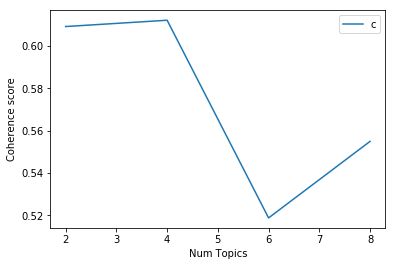

In [51]:
# Show graph
limit=10; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [52]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6092
Num Topics = 4  has Coherence Value of 0.6122
Num Topics = 6  has Coherence Value of 0.5188
Num Topics = 8  has Coherence Value of 0.555


## LDA for no adj + synonyms

In [168]:
# Create Dictionary
data_lemmatized = noadj_toks2
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]]


In [174]:
# create LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [175]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


Perplexity:  -6.739755384325995

Coherence Score:  0.5692528592756909


C:\Users\linyanli\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.389338 -0.151349       1        1  39.467979
5      0.147104  0.168093       2        1  15.683693
3     -0.011988  0.382293       3        1  13.385712
7     -0.001098 -0.091379       4        1  10.536413
4     -0.104076 -0.115442       5        1   8.011793
0     -0.129302 -0.075860       6        1   5.841921
6     -0.143766 -0.063353       7        1   4.535374
2     -0.146211 -0.053004       8        1   2.537122, topic_info=     Category           Freq       Term          Total  loglift  logprob
6     Default  165893.000000     person  165893.000000  30.0000  30.0000
7     Default   34281.000000      posit   34281.000000  29.0000  29.0000
80    Default   47073.000000       food   47073.000000  28.0000  28.0000
5     Default   27940.000000      negat   27940.000000  27.0000  27.0000
9     Default   64406.000000       room   64406.000000  26.0000  26.0000
29    Default   41248.000000      hotel   41248.000000  25.0000  25.0000
18    Default   40538.000000      locat   40538.000000  24.0000  24.0000
37    Default   36154.000000       stay   36154.000000  23.0000  23.0000
88    Default   12962.000000       walk   12962.000000  22.0000  22.0000
28    Default   34906.000000       good   34906.000000  21.0000  21.0000
11    Default   33620.000000      staff   33620.000000  20.0000  20.0000
187   Default   14109.000000        bed   14109.000000  19.0000  19.0000
87    Default   10076.000000    restaur   10076.000000  18.0000  18.0000
1     Default   24992.000000      clean   24992.000000  17.0000  17.0000
335   Default   10093.000000       time   10093.000000  16.0000  16.0000
104   Default    7834.000000    everyth    7834.000000  15.0000  15.0000
281   Default    9742.000000        n't    9742.000000  14.0000  14.0000
25    Default    8500.000000      close    8500.000000  13.0000  13.0000
445   Default    8299.000000       shop    8299.000000  12.0000  12.0000
102   Default    6748.000000       park    6748.000000  11.0000  11.0000
192   Default    9218.000000      night    9218.000000  10.0000  10.0000
184   Default    4830.000000      minut    4830.000000   9.0000   9.0000
430   Default    8817.000000         us    8817.000000   8.0000   8.0000
258   Default    7807.000000      check    7807.000000   7.0000   7.0000
42    Default    8664.000000       area    8664.000000   6.0000   6.0000
0     Default    9232.000000       also    9232.000000   5.0000   5.0000
119   Default    9027.000000       like    9027.000000   4.0000   4.0000
182   Default    8846.000000        one    8846.000000   3.0000   3.0000
54    Default   17618.000000       nice   17618.000000   2.0000   2.0000
24    Default    8746.000000         's    8746.000000   1.0000   1.0000
...       ...            ...        ...            ...      ...      ...
184    Topic8    4829.267578      minut    4830.071289   3.6740  -2.4521
289    Topic8    4042.864990       away    4043.668945   3.6739  -2.6298
153    Topic8    1891.299927      store    1892.103638   3.6737  -3.3895
297    Topic8    1595.081055  transport    1595.884766   3.6736  -3.5599
1210   Topic8    1462.308838    attract    1463.112671   3.6736  -3.6468
2496   Topic8    1386.265869   shinjuku    1387.069214   3.6736  -3.7002
515    Topic8    1217.340454      fabul    1218.144165   3.6735  -3.8301
1212   Topic8    1127.845215       ever    1128.649292   3.6734  -3.9065
1360   Topic8    1115.071533       left    1115.875610   3.6734  -3.9179
1677   Topic8    1053.588501      tokyo    1054.391846   3.6734  -3.9746
295    Topic8    1014.894531     public    1015.698303   3.6733  -4.0120
1424   Topic8    1004.229370       line    1005.033325   3.6733  -4.0226
1103   Topic8     972.827393         ve     973.631653   3.6733  -4.0543
998    Topic8     969.445068      resid     970.248901   3.6733  -4.0578
508    Topic8     904.200745      singl     905.005005   3.

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

## LDA for everything toks2_1

In [176]:
# Create Dictionary
data_lemmatized = toks2_1
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]]


In [177]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [178]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


Perplexity:  -7.111317962865266

Coherence Score:  0.5874024901062587


C:\Users\linyanli\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.003698  0.431052       1        1  23.801474
5      0.313941 -0.130215       2        1  20.491833
6      0.287698  0.006637       3        1  15.418540
2     -0.113589 -0.028684       4        1  11.604874
7     -0.117140 -0.120824       5        1   8.904779
4     -0.124099 -0.004306       6        1   7.060803
0     -0.127195 -0.124286       7        1   6.446798
3     -0.123314 -0.029373       8        1   6.270893, topic_info=     Category          Freq       Term         Total  loglift  logprob
9     Default  65688.000000       room  65688.000000  30.0000  30.0000
18    Default  41761.000000      locat  41761.000000  29.0000  29.0000
30    Default  39482.000000      hotel  39482.000000  28.0000  28.0000
11    Default  34634.000000      staff  34634.000000  27.0000  27.0000
7     Default  34357.000000      posit  34357.000000  26.0000  26.0000
39    Default  35464.000000       stay  35464.000000  25.0000  25.0000
28    Default  34240.000000       good  34240.000000  24.0000  24.0000
6     Default  28002.000000      negat  28002.000000  23.0000  23.0000
29    Default  26596.000000      great  26596.000000  22.0000  22.0000
1     Default  25746.000000      clean  25746.000000  21.0000  21.0000
205   Default  14293.000000        bed  14293.000000  20.0000  20.0000
58    Default  18150.000000       nice  18150.000000  19.0000  19.0000
2     Default  15654.000000     friend  15654.000000  18.0000  18.0000
123   Default  14593.000000       help  14593.000000  17.0000  17.0000
78    Default  15867.000000  breakfast  15867.000000  16.0000  16.0000
169   Default  15062.000000      apart  15062.000000  15.0000  15.0000
69    Default  13607.000000    comfort  13607.000000  14.0000  14.0000
10    Default  14699.000000     servic  14699.000000  13.0000  13.0000
279   Default   7916.000000      check   7916.000000  12.0000  12.0000
271   Default   7435.000000        ...   7435.000000  11.0000  11.0000
492   Default   7212.000000      could   7212.000000  10.0000  10.0000
128   Default   9081.000000       like   9081.000000   9.0000   9.0000
362   Default  10275.000000       time  10275.000000   8.0000   8.0000
93    Default  13387.000000       walk  13387.000000   7.0000   7.0000
199   Default   8901.000000        one   8901.000000   6.0000   6.0000
24    Default   8800.000000         's   8800.000000   5.0000   5.0000
121   Default   7665.000000       food   7665.000000   4.0000   4.0000
304   Default   9917.000000        n't   9917.000000   3.0000   3.0000
33    Default  12829.000000      place  12829.000000   2.0000   2.0000
159   Default   6563.000000      floor   6563.000000   1.0000   1.0000
...       ...           ...        ...           ...      ...      ...
159    Topic8   6562.494629      floor   6563.295410   2.7691  -3.0503
96     Topic8   6371.474609   bathroom   6372.275391   2.7691  -3.0798
192    Topic8   4805.738770      water   4806.539551   2.7691  -3.3619
71     Topic8   4538.561523        new   4539.362305   2.7691  -3.4191
403    Topic8   4438.344238     shower   4439.144531   2.7691  -3.4414
404    Topic8   4170.544434       size   4171.345215   2.7691  -3.5036
74     Topic8   3583.513428       valu   3584.313965   2.7690  -3.6553
887    Topic8   3116.412842      money   3117.213379   2.7690  -3.7950
160    Topic8   3082.537109        got   3083.337891   2.7690  -3.8059
412    Topic8   2757.841309      visit   2758.642090   2.7690  -3.9172
526    Topic8   2494.645020     pillow   2495.445557   2.7689  -4.0175
43     Topic8   2378.594971    airport   2379.395264   2.7689  -4.0652
444    Topic8   2018.095825       hard   2018.896362   2.7689  -4.2295
1262   Topic8   1793.631714     second   1794.432617   2.7688  -4.3474
257    Topic8   1742.114746      light   1742.915283   2.7688  -4.3766
605    Topic8   1673.301270       said   1674.102539   2.7688  -4.4169
601    To

## LDA for no adj

In [179]:
## pos tag and remove adjectives
from nltk import pos_tag
noadj_toks2_1=toks2_1
for sent in noadj_toks2_1:
    sent_pos=pos_tag(sent)
    sent=[s for s in sent_pos if s[1]!='JJ' ]

In [180]:
# Create Dictionary
data_lemmatized = noadj_toks2_1
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]]


In [181]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [182]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


Perplexity:  -7.111317962865266

Coherence Score:  0.5874024901062587


C:\Users\linyanli\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.003698  0.431052       1        1  23.801474
5      0.313941 -0.130215       2        1  20.491833
6      0.287698  0.006637       3        1  15.418540
2     -0.113589 -0.028684       4        1  11.604874
7     -0.117140 -0.120824       5        1   8.904779
4     -0.124099 -0.004306       6        1   7.060803
0     -0.127195 -0.124286       7        1   6.446798
3     -0.123314 -0.029373       8        1   6.270893, topic_info=     Category          Freq       Term         Total  loglift  logprob
9     Default  65688.000000       room  65688.000000  30.0000  30.0000
18    Default  41761.000000      locat  41761.000000  29.0000  29.0000
30    Default  39482.000000      hotel  39482.000000  28.0000  28.0000
11    Default  34634.000000      staff  34634.000000  27.0000  27.0000
7     Default  34357.000000      posit  34357.000000  26.0000  26.0000
39    Default  35464.000000       stay  35464.000000  25.0000  25.0000
28    Default  34240.000000       good  34240.000000  24.0000  24.0000
6     Default  28002.000000      negat  28002.000000  23.0000  23.0000
29    Default  26596.000000      great  26596.000000  22.0000  22.0000
1     Default  25746.000000      clean  25746.000000  21.0000  21.0000
205   Default  14293.000000        bed  14293.000000  20.0000  20.0000
58    Default  18150.000000       nice  18150.000000  19.0000  19.0000
2     Default  15654.000000     friend  15654.000000  18.0000  18.0000
123   Default  14593.000000       help  14593.000000  17.0000  17.0000
78    Default  15867.000000  breakfast  15867.000000  16.0000  16.0000
169   Default  15062.000000      apart  15062.000000  15.0000  15.0000
69    Default  13607.000000    comfort  13607.000000  14.0000  14.0000
10    Default  14699.000000     servic  14699.000000  13.0000  13.0000
279   Default   7916.000000      check   7916.000000  12.0000  12.0000
271   Default   7435.000000        ...   7435.000000  11.0000  11.0000
492   Default   7212.000000      could   7212.000000  10.0000  10.0000
128   Default   9081.000000       like   9081.000000   9.0000   9.0000
362   Default  10275.000000       time  10275.000000   8.0000   8.0000
93    Default  13387.000000       walk  13387.000000   7.0000   7.0000
199   Default   8901.000000        one   8901.000000   6.0000   6.0000
24    Default   8800.000000         's   8800.000000   5.0000   5.0000
121   Default   7665.000000       food   7665.000000   4.0000   4.0000
304   Default   9917.000000        n't   9917.000000   3.0000   3.0000
33    Default  12829.000000      place  12829.000000   2.0000   2.0000
159   Default   6563.000000      floor   6563.000000   1.0000   1.0000
...       ...           ...        ...           ...      ...      ...
159    Topic8   6562.494629      floor   6563.295410   2.7691  -3.0503
96     Topic8   6371.474609   bathroom   6372.275391   2.7691  -3.0798
192    Topic8   4805.738770      water   4806.539551   2.7691  -3.3619
71     Topic8   4538.561523        new   4539.362305   2.7691  -3.4191
403    Topic8   4438.344238     shower   4439.144531   2.7691  -3.4414
404    Topic8   4170.544434       size   4171.345215   2.7691  -3.5036
74     Topic8   3583.513428       valu   3584.313965   2.7690  -3.6553
887    Topic8   3116.412842      money   3117.213379   2.7690  -3.7950
160    Topic8   3082.537109        got   3083.337891   2.7690  -3.8059
412    Topic8   2757.841309      visit   2758.642090   2.7690  -3.9172
526    Topic8   2494.645020     pillow   2495.445557   2.7689  -4.0175
43     Topic8   2378.594971    airport   2379.395264   2.7689  -4.0652
444    Topic8   2018.095825       hard   2018.896362   2.7689  -4.2295
1262   Topic8   1793.631714     second   1794.432617   2.7688  -4.3474
257    Topic8   1742.114746      light   1742.915283   2.7688  -4.3766
605    Topic8   1673.301270       said   1674.102539   2.7688  -4.4169
601    To

In [187]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.052*"..." + 0.051*"could" + 0.043*"free" + 0.043*"park" + 0.037*"bedroom" '
  '+ 0.027*"better" + 0.021*"space" + 0.019*"expect" + 0.017*"complet" + '
  '0.015*"towel"'),
 (1,
  '0.075*"hotel" + 0.067*"stay" + 0.065*"good" + 0.030*"breakfast" + '
  '0.029*"apart" + 0.028*"servic" + 0.025*"walk" + 0.024*"place" + '
  '0.021*"well" + 0.020*"restaur"'),
 (2,
  '0.035*"like" + 0.035*"one" + 0.034*"\'s" + 0.025*"famili" + 0.024*"station" '
  '+ 0.020*"lot" + 0.020*"go" + 0.019*"minut" + 0.018*"citi" + 0.016*"best"'),
 (3,
  '0.103*"bed" + 0.047*"floor" + 0.046*"bathroom" + 0.035*"water" + '
  '0.033*"new" + 0.032*"shower" + 0.030*"size" + 0.026*"valu" + 0.022*"money" '
  '+ 0.022*"got"'),
 (4,
  '0.051*"check" + 0.041*"book" + 0.027*"two" + 0.022*"make" + 0.021*"experi" '
  '+ 0.021*"arriv" + 0.020*"properti" + 0.019*"everi" + 0.017*"made" + '
  '0.016*"manag"'),
 (5,
  '0.124*"room" + 0.092*"locat" + 0.076*"staff" + 0.076*"posit" + '
  '0.062*"negat" + 0.059*"great" + 0.057*"clea

In [ ]:
###### end of word cloud